![](https://raw.githubusercontent.com/SunnySuite/Sunny.jl/main/assets/sunny_logo.jpg)

_This is a tutorial for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package, which enables dynamical simulations of ordered and thermally disordered spins with dipole and higher order moments._


# **Spin Dynamics of the square-lattice Heisenberg antiferromagnet Rb2MnF4**
#### Author: Martin Mourigal (mourigal@gatech.edu)
#### Date: September 7, 2022
#### Version: Julia 1.8,  Sunny 0.4

In this tutorial, we will walk through a first example in Su(n)ny and calculate the spin dynamical properties of Rb<sub>2</sub>MnFe<sub>4</sub>. This material is considered an excellent realization of the 2D square-lattice antiferromagnet, and we will investigate with Sunny how to model the magnetic excitations as a function of temperature.


[1] T Huberman, D A Tennant, R A Cowley, R Coldea and C D Frost, J. Stat. Mech. P05017 (2008) (https://doi.org/10.1088/1742-5468/2008/05/P05017)   
[2] T. Huberman, R. Coldea, R. A. Cowley, D. A. Tennant, R. L. Leheny, R. J. Christianson, and C. D. Frost, Phys. Rev. B 72, 014413 (2005) (https://doi.org/10.1103/PhysRevB.72.014413)

## **Setting up Julia with the necessary packages**


#### A video about how to Install Sunny:
https://mourigal.gatech.edu/public/Sunny-Install-Video-Mourigal.mp4

####  General Information about the Package:
https://github.com/SunnySuite/Sunny.jl

#### Getting Started with Sunny:
https://github.com/SunnySuite/Sunny.jl/blob/main/GettingStarted.md

#### Repository of Tutorials:
https://github.com/SunnySuite/SunnyTutorials

#### Join the Slack workspace of the workshop to ask question:
https://join.slack.com/t/sunny-workshop-2022/shared_invite/zt-1f7urbk1t-A_pvDy6E7s_BGAnTAQMesw

In [1]:
# === Loading Packages ===
using Sunny # The main package
using ProgressMeter, Statistics, Formatting, StaticArrays, LinearAlgebra, DelimitedFiles, OffsetArrays, Random # Some useful peripheral packages
using GLMakie, Plots # Some useful plotting packages
Sunny.offline_viewers(); 

## **Setting up the Crystal Structure**

In [3]:
# === Define the crystal structure ===
xtal_rb2mnf4_full = Crystal("sd_1938747_clean.cif",symprec=0.001);
xtal_rb2mnf4 = subcrystal(xtal_rb2mnf4_full,"Mn1");
display(xtal_rb2mnf4);

# === Define the crystal structure of MgCr2O4 by importing a cif file === 
print_symmetry_table(xtal_rb2mnf4, 8.0);
view_crystal(xtal_rb2mnf4, 8.0)

Crystal
HM symbol 'I 4/m m m' (139)
Lattice params a=4.2, b=4.2, c=13.77, α=90°, β=90°, γ=90°
Cell volume 242.9
Type 'Mn1', Wyckoff 2a (point group '4/mmm'):
   1. [0, 0, 0]
   2. [0.5, 0.5, 0.5]


Site 1
Type 'Mn1', position [0, 0, 0], multiplicity 2
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  B |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*𝒪[2,0] +
    c₂*𝒪[4,0] + c₃*𝒪[4,4] +
    c₄*𝒪[6,0] + c₅*𝒪[6,4]

Bond(1, 1, [1, 0, 0])
Distance 4.2, coordination 4
Connects 'Mn1' at [0, 0, 0] to 'Mn1' at [1, 0, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  0 |
                         | 0  0  C |

Bond(1, 1, [1, 1, 0])
Distance 5.9397, coordination 4
Connects 'Mn1' at [0, 0, 0] to 'Mn1' at [1, 1, 0]
Allowed exchange matrix: | A  C  0 |
                         | C  A  0 |
                         | 0  0  B |

Bond(1, 2, [0, 0, 0])
Distance 7.4982, coordination 8
Connects 'Mn1' at [0, 0, 0] to 'Mn1' at [0.5, 0.5, 0.5]
Allowed exchange matrix: | A  D  C |
                         | D  A  C |
                         | C  C  B |



SunnyViewer(...)

## **Setting up the Exchange Interactions and Local Hilbert Space**

In [4]:
# === Define Local Hilbert Space for Cr ===
lhs_Mn  = [SiteInfo(1; N=0, g=2.0, spin_rescaling=5/2)]; 

# === Define Values of Exchange Interactions ===
val_J1      = 0.648; 
val_δz      = 0.004*val_J1;
val_Jp      = 0.0001*val_J1;

# === Build list of exchange interactions for our system ===
exint_rb2mnf4  = [exchange(val_J1*[1 0 0; 0 1 0; 0 0 1+val_δz],  Bond(1, 1, [1, 0, 0]),"J1"),
                  exchange(val_Jp*[1 0 0; 0 1 0; 0 0 1],  Bond(1, 2, [0, 0, 0]),"Jperp")];

## === Define Super Cell Size ===
scd  = (40,40,4); 

## === Construct the Spin System ===
sys_rb2mnf4 = SpinSystem(xtal_rb2mnf4,  exint_rb2mnf4,  scd, lhs_Mn);

## === Randomize the Spins ===
rand!(sys_rb2mnf4);            


## **Thermalizing the System**

In [5]:
## === Construct Langevin Sampler ===
nLA = 50;   # Number of Langevin time steps performed each time the sampler is invoked
α   = 0.1;  # Langevin damping, usually 0.05-0.2 is good.
dt  = 0.01; # Time steps during Langevin evolution
kT  = val_J1*20; # Initializing spin system at some finite temperature corresponding to 20 times J1 (to be well paramagnetic)
sam_LA_rb2mnf4  = LangevinSampler(sys_rb2mnf4, kT, α, dt, nLA);

## === Thermalize system to the temperature said below using Langevin===
kT     = 5.0; # Target temperature in meV
nTherm = 100; # Number of times the sampler is invoked to thermalize
set_temp!(sam_LA_rb2mnf4,kT); 
thermalize!(sam_LA_rb2mnf4,nTherm);

In [6]:
## === Do Simulations at a Given Temperature===
kT  = 0.5; # Target temperature in meV
set_temp!(sam_LA_rb2mnf4,kT); 

##  === Calculate SQ ===
nsam        = 10; # Number of samples that are averaged over (usually 10 is good)
nTherm      = 10;
bz_size     = (2,2,2); # Size of the resulting extended Brillouin zone after FFT
@time begin
sq_rb2mnf4 = static_structure_factor(sys_rb2mnf4, sam_LA_rb2mnf4;
             nsamples=nsam, bz_size=bz_size, thermalize=nTherm, verbose=false, reduce_basis=true, dipole_factor=true)
end

##  === Calculate SQW ===
nsam      = 10; # Number of samples that are averaged over (usually 10 is good)
nTherm    = 10;
bz_size   = (2,2,2); # Size of the resulting extended Brillouin zone after FFT
dt        = 0.02;
nw        = 100;
wmax      = val_J1*15;
@time begin
sqw_rb2mnf4 = dynamic_structure_factor(sys_rb2mnf4, sam_LA_rb2mnf4;
    nsamples=nsam, thermalize=nTherm, dt=dt, num_omegas=nw, omega_max=wmax, 
    bz_size=bz_size, reduce_basis=true, dipole_factor=true, verbose=true)
end

  9.294921 seconds (38.56 M allocations: 2.244 GiB, 5.27% gc time, 64.58% compilation time)
Beginning thermalization...
Done thermalizing. Beginning measurements...


Sample: 100%|███████████████████████████████████████████| Time: 0:02:43


164.252958 seconds (116.97 M allocations: 30.416 GiB, 1.79% gc time, 0.12% compilation time)


80x80x8x100 StructureFactor

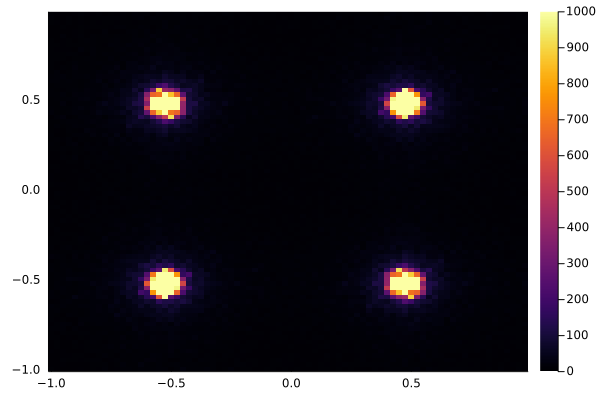

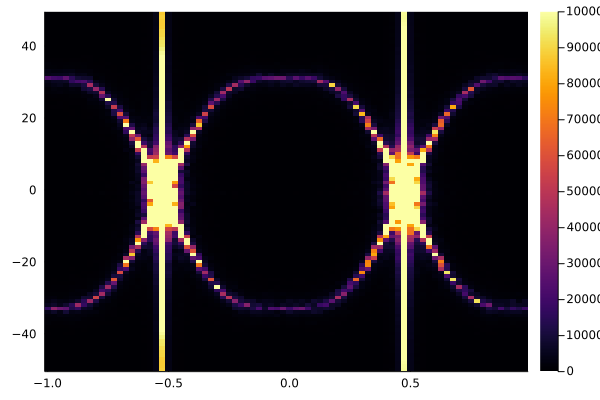

In [9]:
#  === Create a function to plot S(Q) ===
function PlotSQ(input_sq, input_sys; Slice, Imax)
    Q1   = range(input_sq.sfactor.offsets[1],length=size(input_sq.sfactor)[1])/size(input_sys.lattice)[1];
    Q2   = range(input_sq.sfactor.offsets[2],length=size(input_sq.sfactor)[2])/size(input_sys.lattice)[2];
    Q3   = range(input_sq.sfactor.offsets[3],length=size(input_sq.sfactor)[3])/size(input_sys.lattice)[3];
    midQ = Int64(size(Q1)[1]/2);
    Int = input_sq.sfactor[:,:,Slice,0]/prod(size(input_sys.lattice));
    return display(Plots.heatmap(Q1,Q2,Int,clim=(0,Imax),fmt = :png));   
end

#  === Create a function to plot S(Q,W) ===
function PlotSQW(input_sqw, input_sys; Slice1, Slice2, Imax)
    Q1   = range(input_sqw.sfactor.offsets[1],length=size(input_sqw.sfactor)[1])/size(input_sys.lattice)[1];
    Q2   = range(input_sqw.sfactor.offsets[2],length=size(input_sqw.sfactor)[2])/size(input_sys.lattice)[2];
    Q3   = range(input_sqw.sfactor.offsets[3],length=size(input_sqw.sfactor)[3])/size(input_sys.lattice)[3];
    EN   = range(input_sqw.sfactor.offsets[4],length=size(input_sqw.sfactor)[4]);
    midQ = Int64(size(Q1)[1]/2);
    Int  = input_sqw.sfactor[:,:,:,:]/prod(size(input_sys.lattice));
    return display(Plots.heatmap(Q1,EN,Int[:,Slice1,Slice2,:]',clim=(0,Imax),fmt = :png));   
end

#  === Plots ===
PlotSQ(sq_rb2mnf4, sys_rb2mnf4; Slice=0, Imax=1000)
PlotSQW(sqw_rb2mnf4, sys_rb2mnf4; Slice1=20, Slice2=0, Imax=50000);


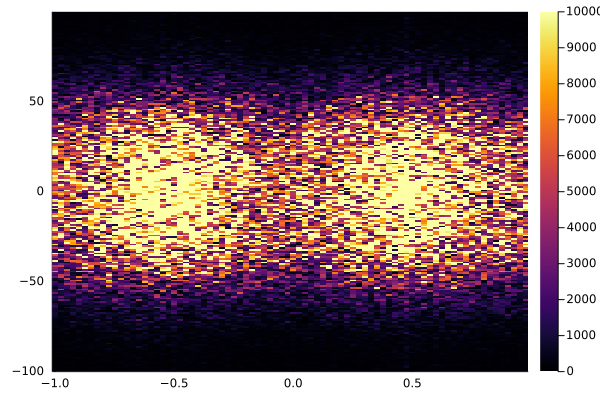

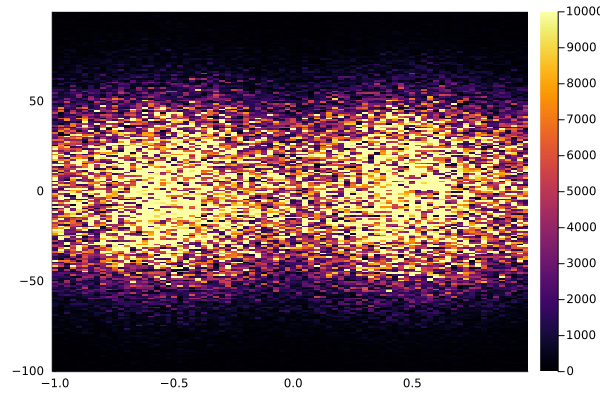

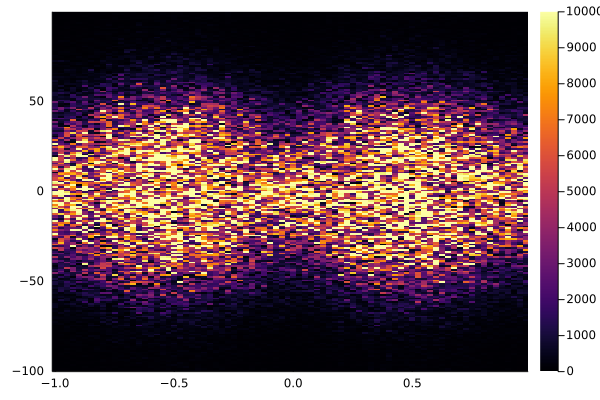

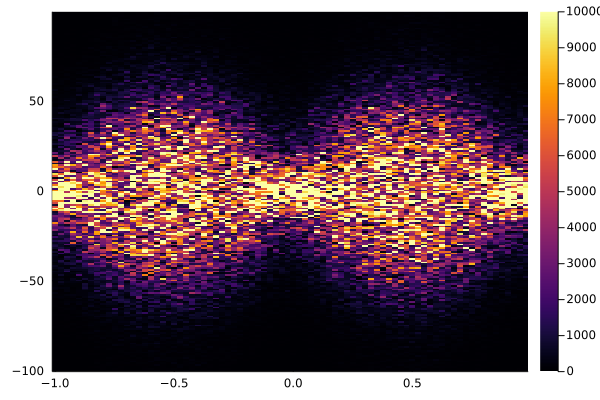

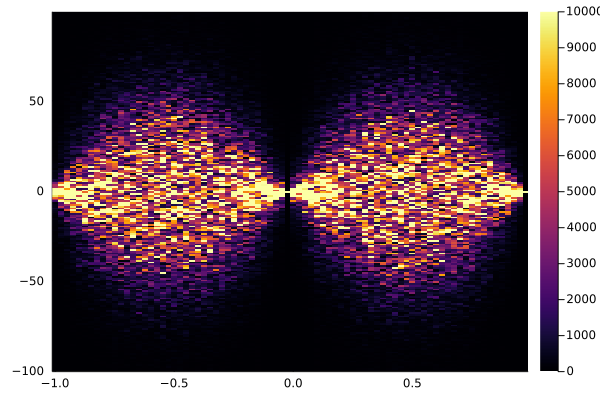

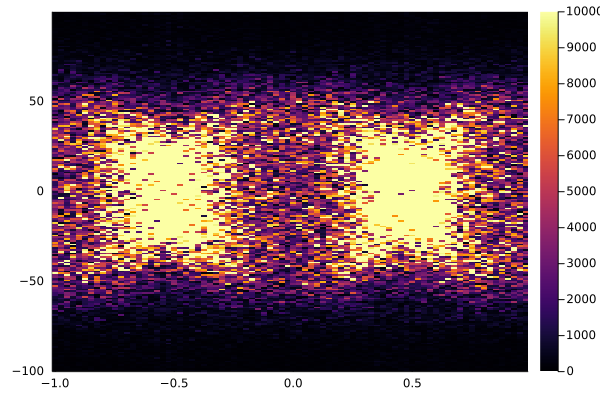

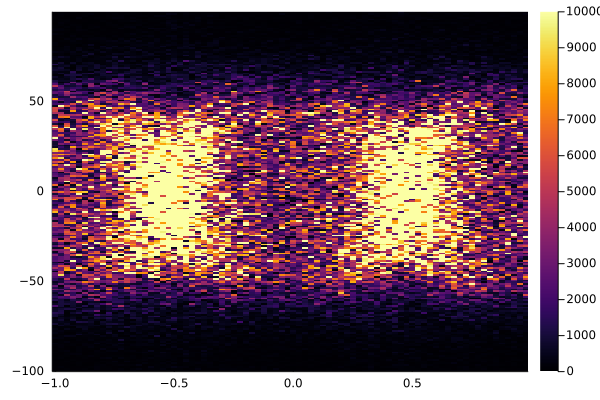

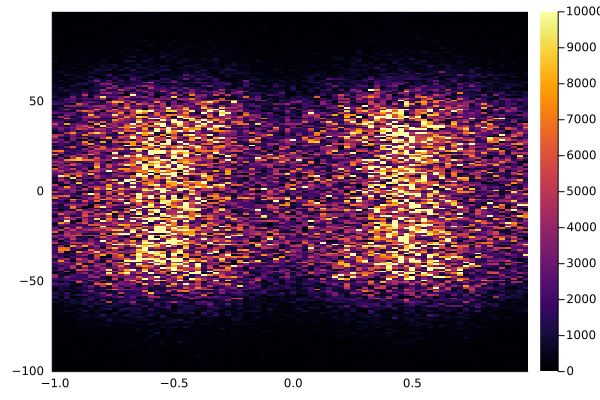

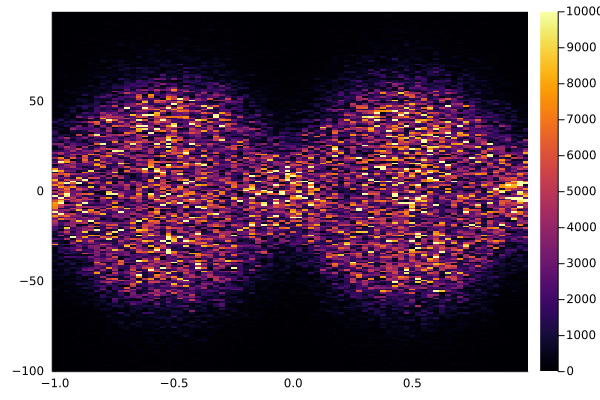

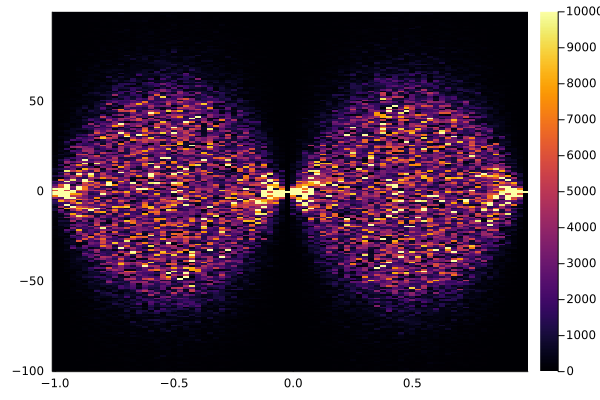

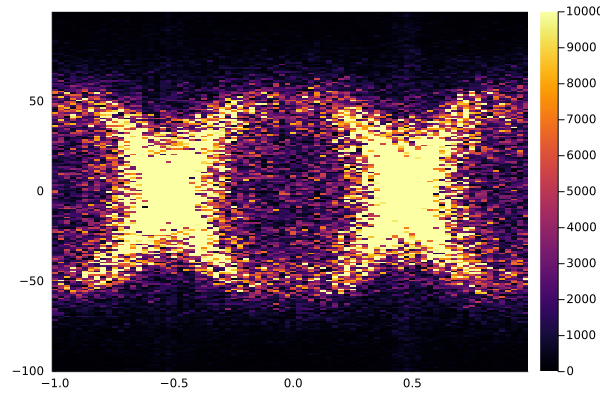

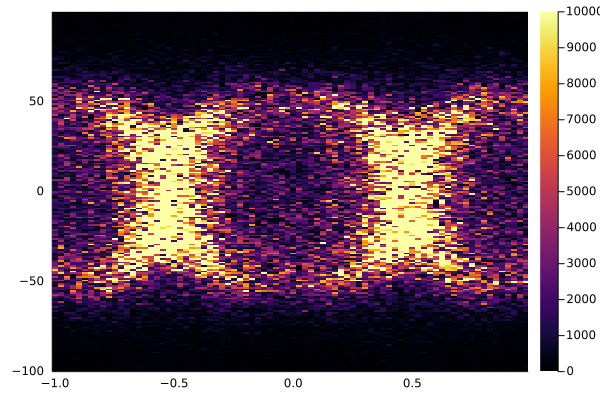

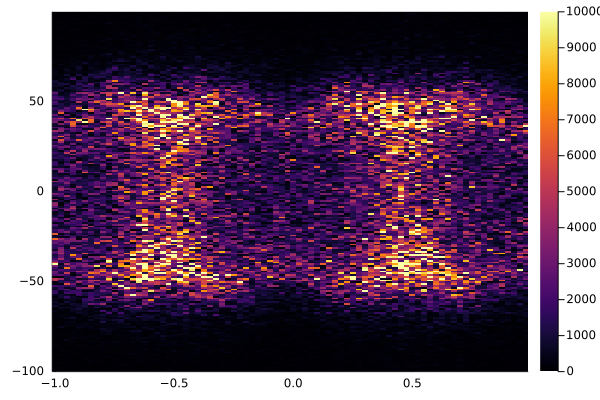

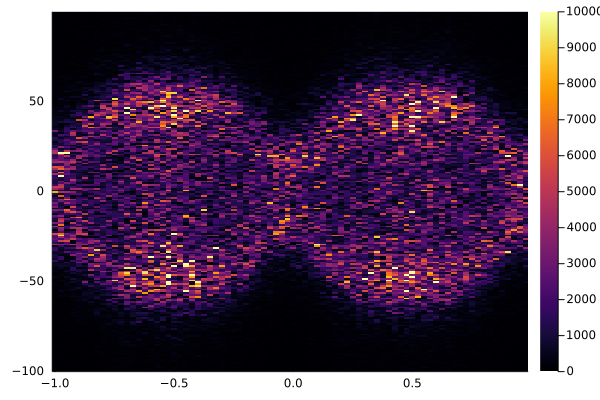

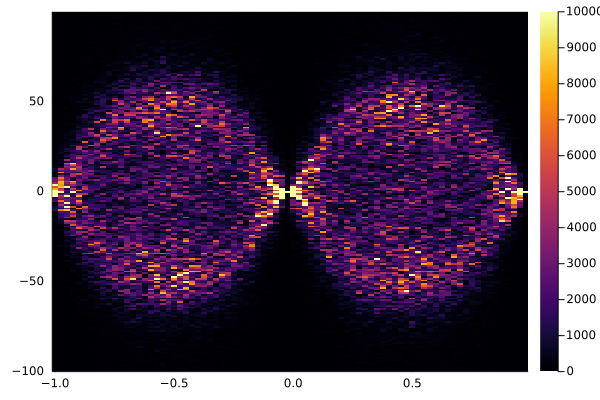

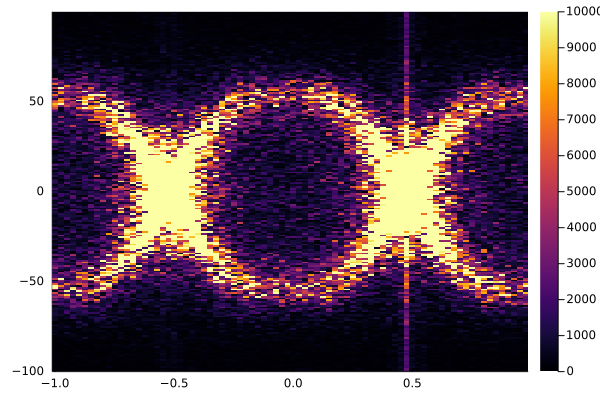

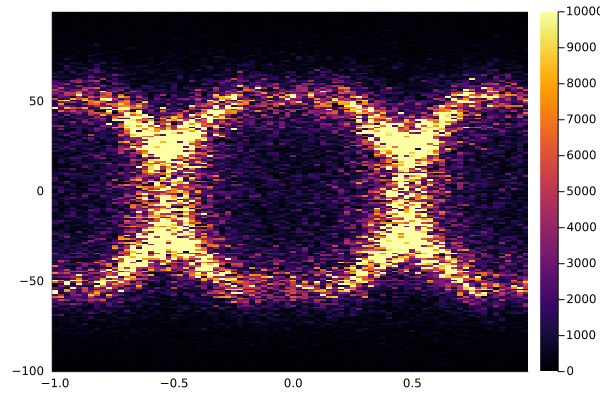

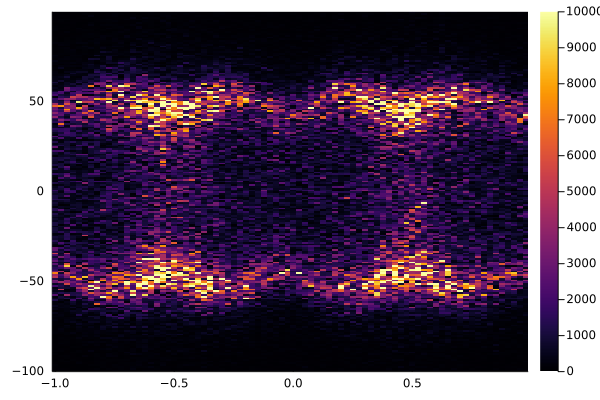

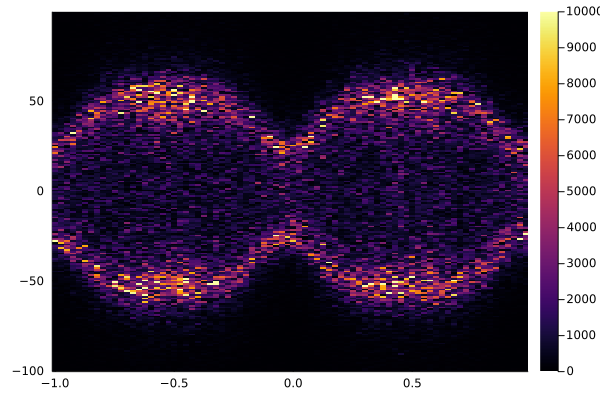

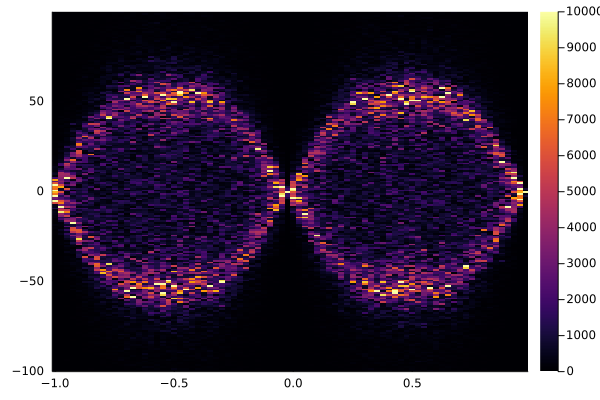

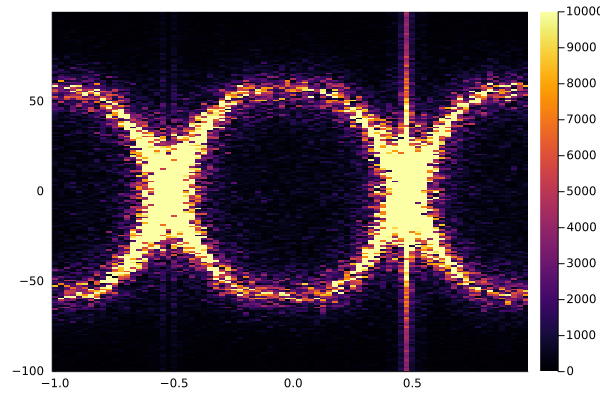

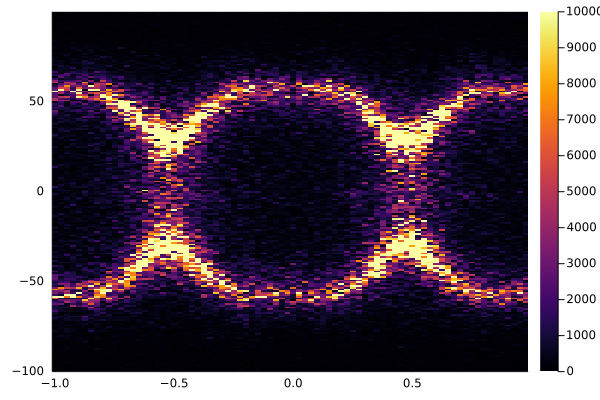

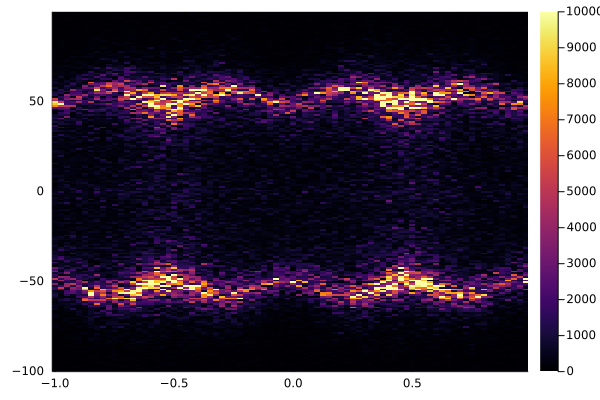

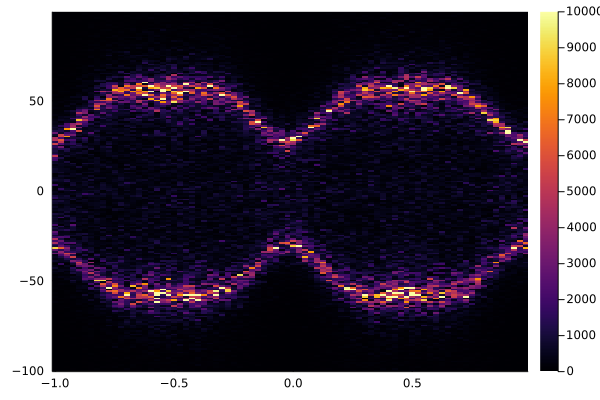

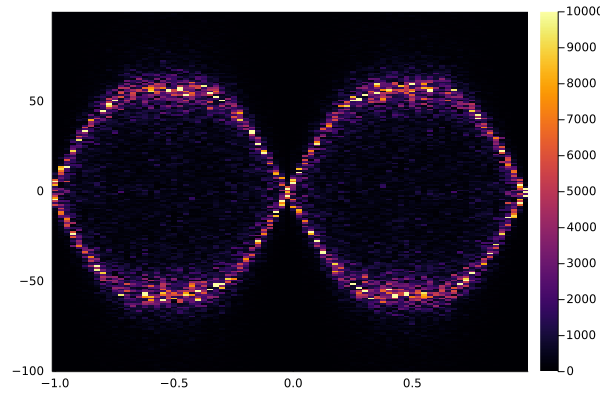

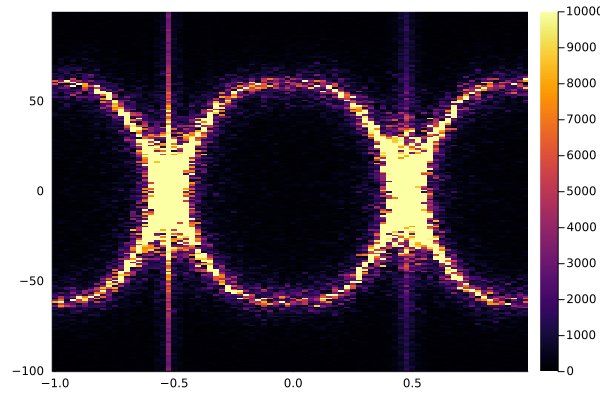

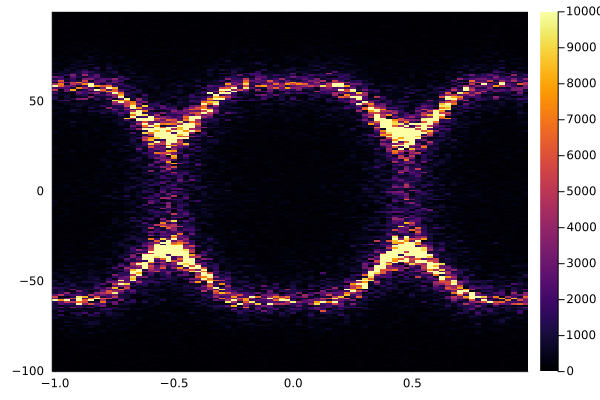

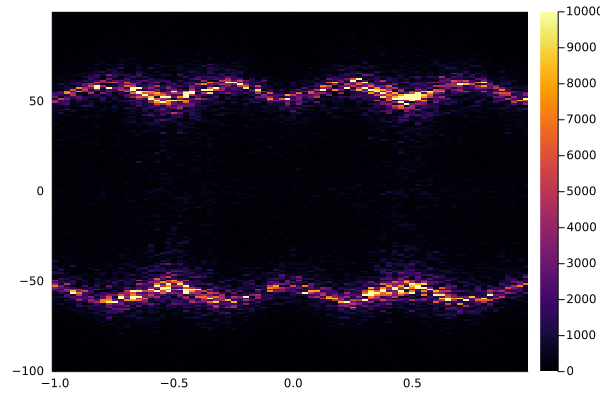

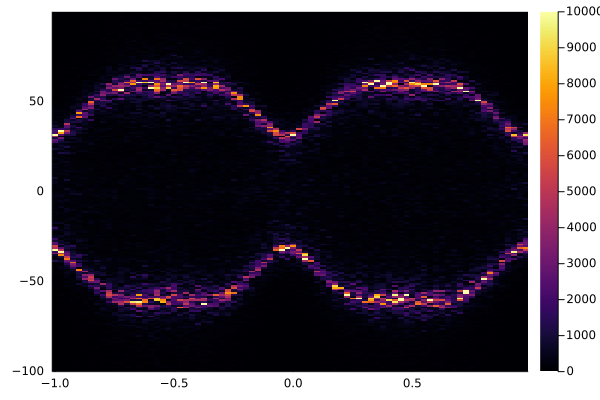

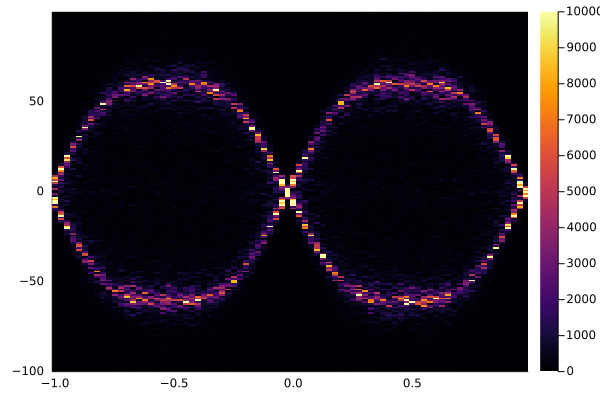

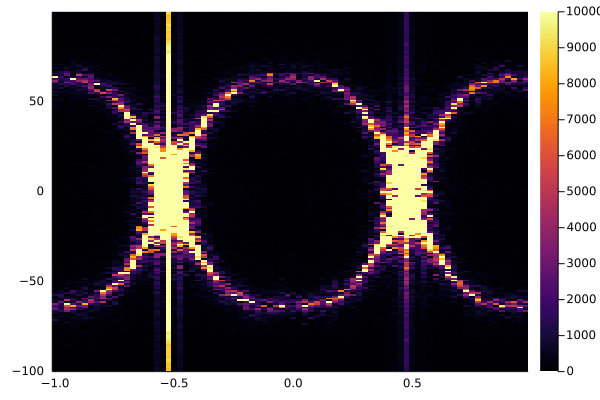

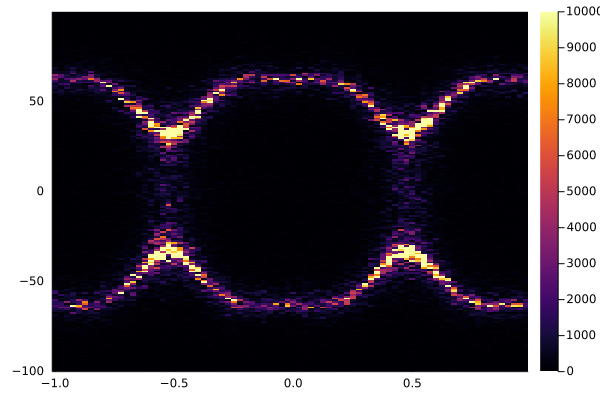

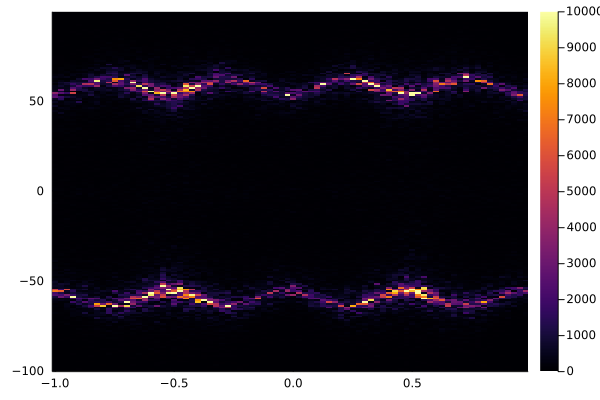

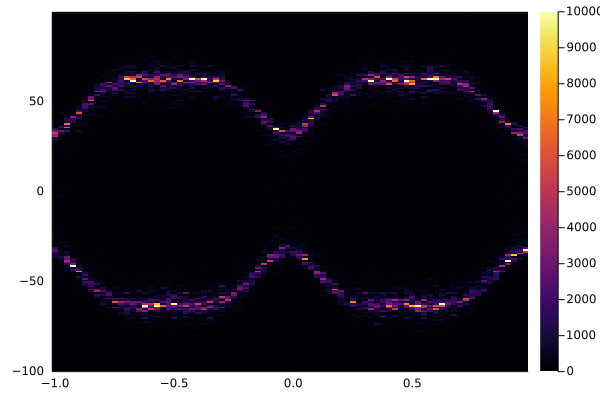

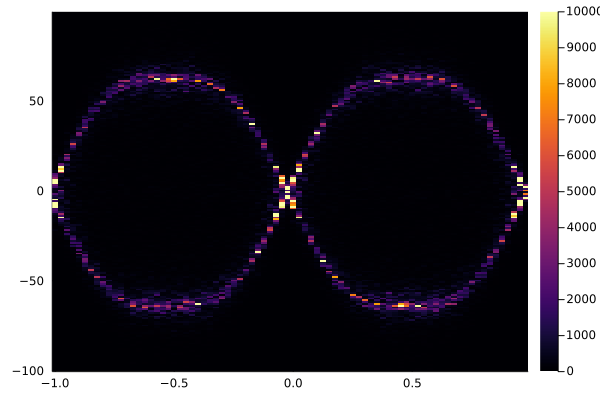

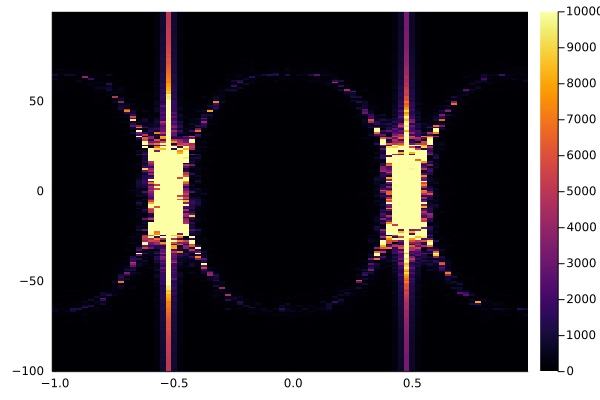

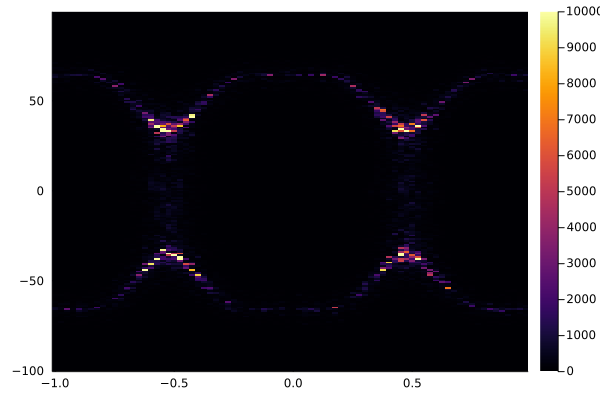

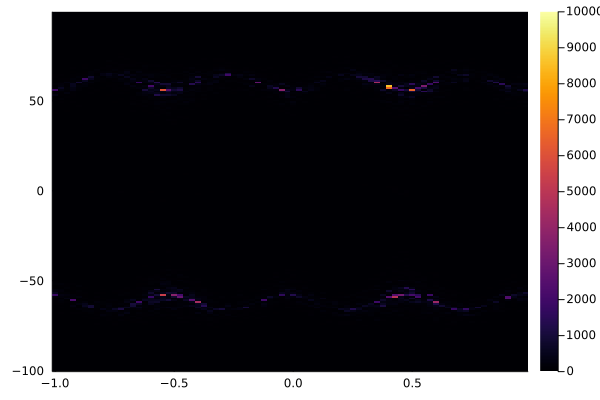

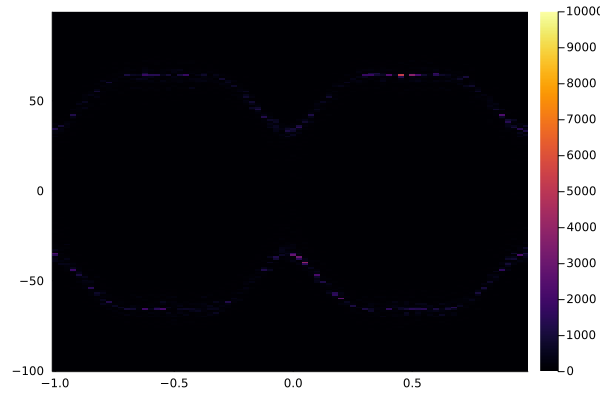

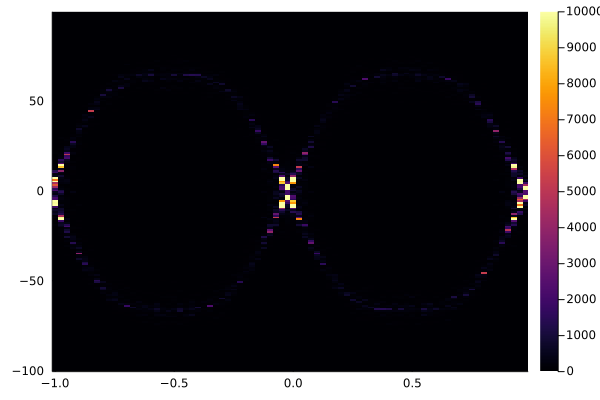

287.592209 seconds (184.66 M allocations: 57.948 GiB, 1.94% gc time, 0.02% compilation time)


In [10]:
##  === Calculate SQW ===
nsam      = 1; # Number of samples that are averaged over (usually 10 is good)
nTherm    = 1;
bz_size   = (2,2,2); # Size of the resulting extended Brillouin zone after FFT
dt        = 0.02;
nw        = 200;
wmax      = val_J1*15;
kTSchedule = [10.0 3.0 2.5 2.0 1.5 1.0 0.5 0.01];
@time begin
    for j=1:length(kTSchedule)
        set_temp!(sam_LA_rb2mnf4,kTSchedule[j]); 
        sqw_rb2mnf4 = dynamic_structure_factor(sys_rb2mnf4, sam_LA_rb2mnf4;
            nsamples=nsam, thermalize=nTherm, dt=dt, num_omegas=nw, omega_max=wmax, 
            bz_size=bz_size, reduce_basis=true, dipole_factor=true, verbose=false)
            PlotSQW(sqw_rb2mnf4, sys_rb2mnf4; Slice1=20, Slice2=0, Imax=10000);
            PlotSQW(sqw_rb2mnf4, sys_rb2mnf4; Slice1=15, Slice2=0, Imax=10000);
            PlotSQW(sqw_rb2mnf4, sys_rb2mnf4; Slice1=10, Slice2=0, Imax=10000);
            PlotSQW(sqw_rb2mnf4, sys_rb2mnf4; Slice1=5, Slice2=0, Imax=10000);
            PlotSQW(sqw_rb2mnf4, sys_rb2mnf4; Slice1=0, Slice2=0, Imax=10000);
    end
end